# The Gresho Vortex Test

This problem tests the code for conservation of angular momentum and for its ability to maintain a dynamical equilibrium state. To do this, we initialize a stable, time-independent vortex by balancing the centrifugal force with the gradient of the initial pressure profile. Explicitly, we set:
$$ v_\theta(r)=   \left\{
\begin{array}{ll}
      5r & 0\leq r < 0.2 \\
      2-5r & 0.2 \leq r < 0.4 \\
      0 & r > 0.4 \\
\end{array} 
\right.  
$$
In other words, this test initializes a radially varying angular velocity profile that grows linearly till a peak at $r=0.2$ (the midpoint of the disk), after which it decreases linearly to the edge/rim of the disk. The corresponding pressure profile (that balances the centrifugal force generated by this rotational velocity) is:
$$ P(r)=   \left\{
\begin{array}{ll}
      5+\frac{25}{2}r^2 & 0\leq r < 0.2 \\
      9+\frac{25}{2}r^2-20r+4\ln\big(\frac{r}{0.2}\big) & 0.2 \leq r < 0.4 \\
      3+4\ln(2) & r > 0.4 \\
\end{array} 
\right.  
$$
Because this initial condition is pure rotation (a vortex), we expect that the vortex should maintain its shape throughout the simulation.

### Implementation
Again, we begin by importing the relevant packages. As before (see Sod Test), this problem can be easily run in parallel – one must simply combine the necessary code blocks into a single python program and use the command
```
mpirun -n 4 python your_program_name.py
``` 
and the code will recognize that you are running in parallel and will alter the computation accordingly.

In [1]:
import phd
import numpy as np

Next we want to write a method to set up our initial conditions. Because the code takes its inputs in cartesian coordinates, we can compute the angular velocity in polar coordinates and convert back to the $xy$ components for the `particles` object.

In [2]:
def create_particles(dim=2, nx=45, Lx=1., gamma=1.4, units = "cgs"):

    dx = Lx/nx # spacing between particles
    n = nx*nx  # number of points

    # create particle container, which implicitly assumes cgs
    particles, units = phd.HydroParticleCreator(n, dim=2)
    part = 0
    for i in range(nx):
        for j in range(nx):

            x = (i+0.5)*dx - 0.5
            y = (j+0.5)*dx - 0.5

            # convert to polar coordinates
            theta = np.arctan2(y, x)                         
            r = np.sqrt(x**2 + y**2)

            if 0 <= r < 0.2:
                vtheta = 5*r
                press = 5 + 25./2*r**2

            elif 0.2 <= r < 0.4:
                vtheta = 2 - 5*r
                press = 9 + 25./2*r**2 - 20.*r + 4*np.log(r/0.2)

            else:
                vtheta = 0.
                press = 3 + 4*np.log(2)

            particles["position-x"][part] = x + 0.5
            particles["position-y"][part] = y + 0.5
            
            # recover the cartesian components
            particles["velocity-x"][part] = -np.sin(theta)*vtheta        
            particles["velocity-y"][part] =  np.cos(theta)*vtheta
            particles["pressure"][part] = press 
            particles["ids"][part] = part
            part += 1

    # set ambient values
    particles["density"][:] = 1.0

    return particles, units

The rest is easy! We can build all the different components of the simulation (i.e. domain, Riemann solver, output information, stoppage criteria, etc.). With this problem, we can use the `TimeInterval` method, which allows us to specify how frequently the simulation should produce output files (in this case, at an interval of 0.5). Unlike with the Sod Shock Tube, here we will just proceed with the ``Units`` object returned by the particle creator method.

In [3]:
dim = 2; gamma = 1.4
particles, units = phd.distribute_initial_particles(
                    create_particles, dim=dim, gamma=gamma, units = "cgs")

# computation related to boundaries
domain_manager = phd.DomainManager(
        xmin=[0., 0.], xmax=[1., 1.],
        initial_radius=0.1)

# create voronoi mesh
mesh = phd.Mesh()

# computation
integrator = phd.MovingMeshMUSCLHancock()
integrator.set_mesh(mesh)
integrator.set_riemann(phd.HLLC())
integrator.set_particles(particles)
integrator.set_domain_manager(domain_manager)
integrator.set_boundary_condition(phd.Periodic())
integrator.set_reconstruction(phd.PieceWiseLinear())
integrator.set_equation_state(phd.IdealGas(gamma=gamma))
integrator.set_units(units)

sim_name = "gresho"
if phd._in_parallel:
    integrator.set_load_balance(phd.LoadBalance())
    sim_name = "mpi_gresho"

# add finish criteria
simulation_time_manager = phd.SimulationTimeManager()
simulation_time_manager.add_finish(phd.Time(time_max=3.0))

# output initial state
output = phd.InitialOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output last step
output = phd.FinalOutput()
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

# output every 0.5 time interval
output = phd.TimeInterval(time_interval=0.5)
output.set_writer(phd.Hdf5())
simulation_time_manager.add_output(output)

Finally, we sit back and run the simulation.

In [4]:
# Create simulator
simulation = phd.Simulation(simulation_name=sim_name, log_level = "startup")
simulation.set_integrator(integrator)
simulation.set_simulation_time_manager(simulation_time_manager)
simulation.initialize()
simulation.solve()

phd: [STARTUP  ] 2021-07-28 10:36:17,954: 

 __________.__         .___
\______   \  |__    __| _/
 |     ___/  |  \  / __ |
 |    |   |   Y  \/ /_/ |
 |____|   |___|  /\____ |
               \/      \/
Welcome to Python Hydro-Dynamics!

Simulation Information
------------------------------
Running in serial
Log file saved at: gresho.log
Problem solving: gresho
Output data will be saved at: gresho_output

Classes used in the simulation
------------------------------
boundary_condition: Periodic
domain_manager: DomainManager
equation_state: IdealGas
integrator: MovingMeshMUSCLHancock
mesh: Mesh
particles: CarrayContainer
reconstruction: PieceWiseLinear
riemann: HLLC
units: Units

phd: [SUCCESS  ] 2021-07-28 10:37:04,337: Simulation successfully finished!


Now we can analyze the outputs to see that the code has preserved the vortex quite well! In order to directly display the velocity in the Voronoi cells in the simulation, we make use of the `vor_collection` method, which allows us to generate a series of polygonal patches that represent the Voronoi tessellation and returns the corresponding $v_\phi$ values for easy plotting with matplotlib collections and colors. To do this, we first extract the simulation state into the `vortex` object. Next, because the simulation is tracked in Cartesian coordinates, we introduce ("register") two new Carray fields, and populate them with the corresponding polar components of position and velocity. Then, we can feed that object into the `vor_collection` method to generate a `PatchCollection` that can be plotted.

phd: [INFO     ] 2021-04-12 19:06:39,688: hdf5 format: Reading filename gresho_output/initial_output/initial_output0000/initial_output0000.hdf5
phd: [INFO     ] 2021-04-12 19:06:39,919: hdf5 format: Reading filename gresho_output/time_interval/time_interval0000/time_interval0000.hdf5
phd: [INFO     ] 2021-04-12 19:06:40,141: hdf5 format: Reading filename gresho_output/final_output/final_output0000/final_output0000.hdf5


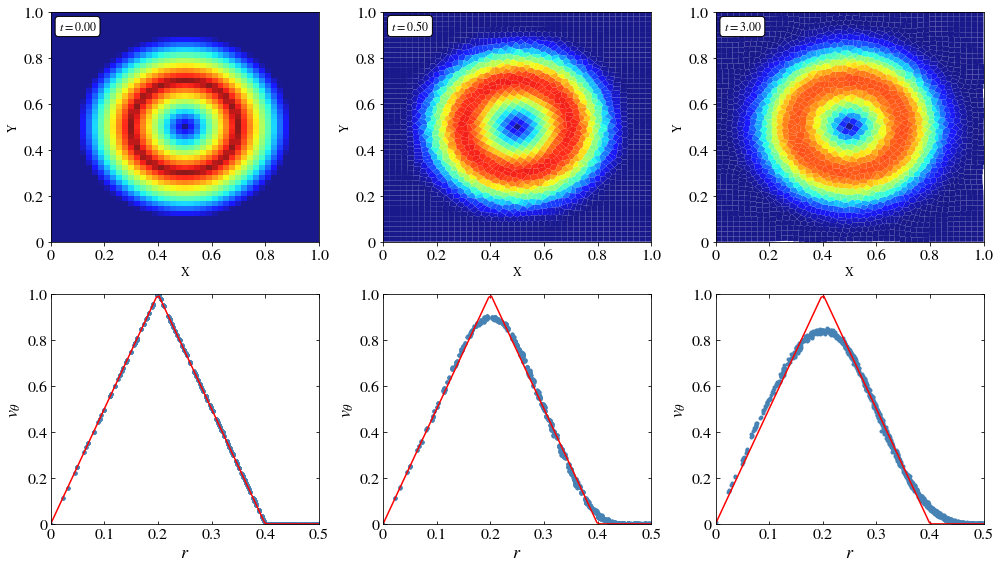

In [5]:
# imports
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["xtick.labelsize"] = 16
mpl.rcParams["ytick.labelsize"] = 16

# create exact solution (should just reproduce the initial conditions)
radius = np.linspace(0, 0.5, 100)
sol = np.zeros(radius.size)

for i in range(sol.size):
    r = radius[i]
    if 0 <= r < 0.2:
        sol[i] = 5*r
    elif 0.2 <= r < 0.4:
        sol[i] = 2 - 5*r
    else:
        sol[i] = 0.
        
files = [
        "gresho_output/initial_output/initial_output0000/initial_output0000.hdf5",
        "gresho_output/time_interval/time_interval0000/time_interval0000.hdf5",
        "gresho_output/final_output/final_output0000/final_output0000.hdf5"
        ]

fig, axes = plt.subplots(2,3, figsize=(14,8))

for i, fi in enumerate(files):

    reader = phd.Hdf5()
    vortex, units = reader.read(fi)
    time = h5py.File(fi, "r").attrs["time"]

    # introduce two new fields for the polar coordinates
    vortex.register_carray(vortex.get_carray_size(),
            "v-theta", "double")
    vortex.register_carray(vortex.get_carray_size(),
            "rad", "double")

    # put position and velocity in polar coordinates
    theta = np.arctan2(vortex["position-y"]-0.5, vortex["position-x"]-0.5)
    vortex["rad"][:] = np.sqrt((vortex["position-x"]-0.5)**2 + (vortex["position-y"]-0.5)**2)
    vortex["v-theta"][:] = (-np.sin(theta)*vortex["velocity-x"] + np.cos(theta)*vortex["velocity-y"])

    # generate the collection of positions and corresponding velocities
    patch, colors = phd.vor_collection(vortex, "v-theta")
    vortex.remove_tagged_particles(phd.ParticleTAGS.Ghost)

    # plotting
    p = PatchCollection(patch, edgecolor="none", linewidth=0.1, cmap="jet", alpha=0.9)
    p.set_array(np.array(colors))
    p.set_clim([0, 1.0])
    ax = axes[0,i]
    ax.text(0.03, 0.92, r"$t=%0.2f$" % time, fontsize=12,
            bbox=dict(boxstyle="round", facecolor="white"))
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.add_collection(p)

    ax = axes[1,i]
    ax.plot(vortex["rad"], vortex["v-theta"], ".", color="steelblue", label="simulation")
    ax.plot(radius, sol, "red")
    ax.set_ylabel(r"$v_\theta$", fontsize=18)
    ax.set_xlabel(r"$r$", fontsize=18)
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim(0,0.5)
    ax.set_ylim(0,1)
    ax.tick_params(direction="in", right=True, top=True)

fig.tight_layout()
plt.savefig("gresho_vortex.png")
plt.show()

Our initial grid (upper left panel) is a collection of rectangular pixels by construction. Evidently, as the system evolves, the rotating cells are deformed into irregular polygons and the angular velocity is smoothed near the sharp boundaries (at the center of the disk and the rim), but, on the whole, the system maintains the dynamical equilibrium structure of the initial conditions.